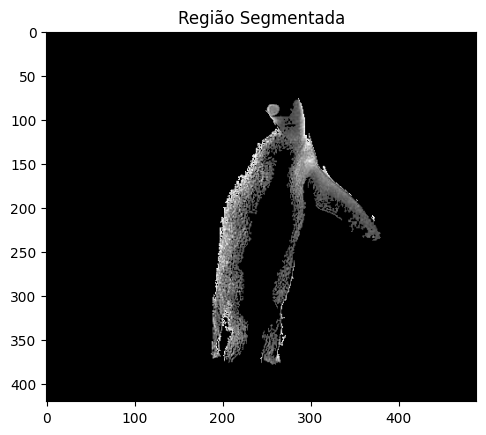

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from collections import deque
# Carrega a imagem em grayscale
img = cv2.imread("./pinguim.jpg", cv2.IMREAD_GRAYSCALE).astype(np.float32)
row, col = img.shape
mat = np.zeros_like(img, dtype=np.int32)
def expansion_iterativa(img, seed_x, seed_y, threshold):
    counter = 1
    fila = deque()
    fila.append((seed_x, seed_y))
    intensidade_inicial = img[seed_x, seed_y]
    while fila:
        x, y = fila.popleft()
        if mat[x, y] != 0:
            continue
        if abs(img[x, y] - intensidade_inicial) <= threshold:
            mat[x, y] = counter
            # Vizinhança 4
            if x + 1 < row:
                fila.append((x + 1, y))
            if x - 1 >= 0:
                fila.append((x - 1, y))
            if y + 1 < col:
                fila.append((x, y + 1))
            if y - 1 >= 0:
                fila.append((x, y - 1))
# Chamada da função com ponto semente e limiar
expansion_iterativa(img, 230, 220, 50)
# Exibe o resultado
def mostrar_regiao(img, mat):
    # Cria uma imagem com os mesmos valores da original onde mat == 1, e 0 no restante
    regiao = np.zeros_like(img)
    regiao[mat == 1] = img[mat == 1]
    regiao[mat == 2] = img[mat == 2]
    return regiao
regiao_segmentada = mostrar_regiao(img, mat)
plt.imshow(regiao_segmentada, cmap='gray')
plt.title('Região Segmentada')
plt.show()


Image loaded: 489x420

--- Starting Split Phase ---
--- Split Phase Finished (0.41s) ---
    Regions after split: 3775

--- Starting Merge Phase ---
Starting merge phase with 3775 regions...
 Merge pass - current regions: 3775
   Removing 1816 merged regions.
 Merge pass finished in 0.79s. Regions remaining: 1959
 Merge pass - current regions: 1959
   Removing 804 merged regions.
 Merge pass finished in 0.89s. Regions remaining: 1155
 Merge pass - current regions: 1155
   Removing 286 merged regions.
 Merge pass finished in 0.71s. Regions remaining: 869
 Merge pass - current regions: 869
   Removing 87 merged regions.
 Merge pass finished in 0.66s. Regions remaining: 782
 Merge pass - current regions: 782
   Removing 29 merged regions.
 Merge pass finished in 0.23s. Regions remaining: 753
 Merge pass - current regions: 753
   Removing 10 merged regions.
 Merge pass finished in 0.42s. Regions remaining: 743
 Merge pass - current regions: 743
   Removing 5 merged regions.
 Merge pass fin

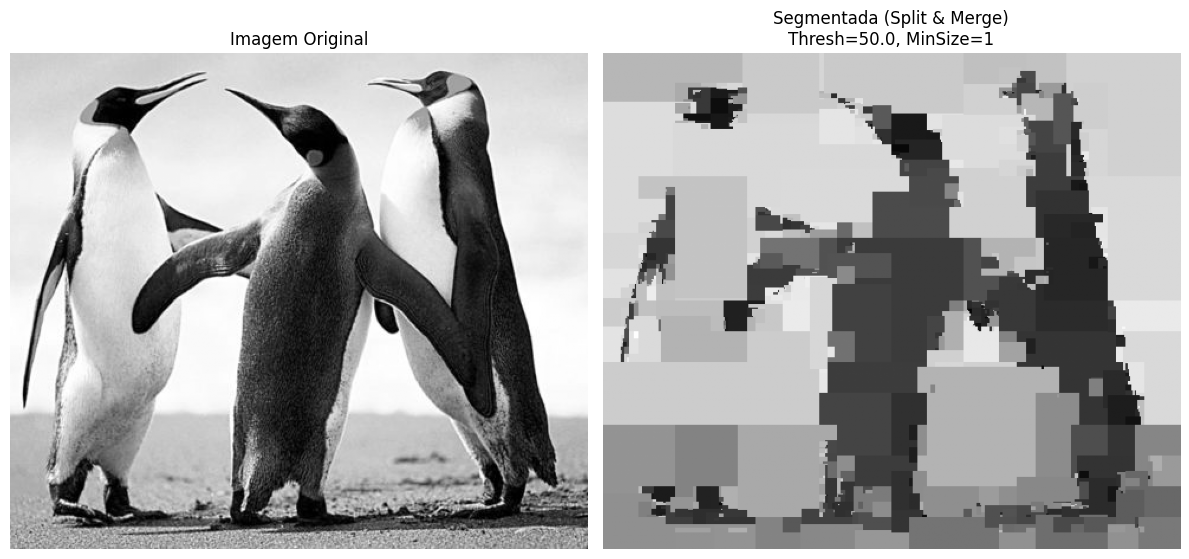

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import time # Para medir o tempo

# --- 1. Predicado de Homogeneidade ---
# Decide se uma região é "uniforme" o suficiente.
# Usaremos o desvio padrão como critério.
def predicate_std_dev(region_data, threshold):
    """
    Verifica se o desvio padrão da região está abaixo do limiar.
    Retorna True se homogêneo, False caso contrário.
    """
    if region_data.size == 0:
        return True # Região vazia é homogênea

    # Adiciona epsilon para evitar std=0 em regiões perfeitamente constantes
    # e problemas com limiar muito baixo.
    std_dev = np.std(region_data)
    # print(f"  Region size: {region_data.shape}, Std Dev: {std_dev:.2f}") # Debug
    return std_dev < threshold

# --- 2. Fase de Divisão (Split) Recursiva ---
# Divide a imagem em quadrantes até que todas as regiões sejam homogêneas.
def recursive_split(image, x, y, w, h, predicate_func, threshold, min_size=1):
    """
    Divide recursivamente uma região da imagem.

    Args:
        image (np.array): Imagem completa em tons de cinza (float).
        x, y (int): Coordenadas do canto superior esquerdo da região atual.
        w, h (int): Largura e altura da região atual.
        predicate_func (function): Função predicado (ex: predicate_std_dev).
        threshold (float): Limiar para o predicado.
        min_size (int): Tamanho mínimo da região (largura ou altura) para parar a divisão.

    Returns:
        list: Lista de tuplas (x, y, w, h) representando as regiões homogêneas finais.
    """
    # Extrai os dados da região atual
    current_region_data = image[y : y + h, x : x + w]

    # --- Condição de Parada ---
    # A região é homogênea OU atingiu o tamanho mínimo?
    if predicate_func(current_region_data, threshold) or w <= min_size or h <= min_size:
        # print(f"Homogeneous or small enough: {(x, y, w, h)}") # Debug
        return [(x, y, w, h)] # Retorna a própria região

    # --- Divisão ---
    else:
        # print(f"Splitting region: {(x, y, w, h)}") # Debug
        # Calcula as dimensões dos 4 quadrantes
        w2 = w // 2
        h2 = h // 2

        # Lida com dimensões ímpares (garante que a imagem toda seja coberta)
        dw1 = w2
        dh1 = h2
        dw2 = w - w2 # Largura restante (pode ser w2 ou w2+1)
        dh2 = h - h2 # Altura restante

        # Verifica se a divisão é realmente possível (evita loop infinito se w2 ou h2 for 0)
        if w2 == 0 or h2 == 0:
             # print(f"Cannot split further (w2={w2}, h2={h2}): {(x, y, w, h)}") # Debug
             return [(x, y, w, h)] # Não pode dividir mais

        # Chamada recursiva para cada quadrante
        regions = []
        # Top-Left
        regions.extend(recursive_split(image, x, y, dw1, dh1, predicate_func, threshold, min_size))
        # Top-Right (verifica se dw2 > 0)
        if dw2 > 0:
            regions.extend(recursive_split(image, x + dw1, y, dw2, dh1, predicate_func, threshold, min_size))
        # Bottom-Left (verifica se dh2 > 0)
        if dh2 > 0:
            regions.extend(recursive_split(image, x, y + dh1, dw1, dh2, predicate_func, threshold, min_size))
        # Bottom-Right (verifica se dw2 > 0 e dh2 > 0)
        if dw2 > 0 and dh2 > 0:
            regions.extend(recursive_split(image, x + dw1, y + dh1, dw2, dh2, predicate_func, threshold, min_size))

        return regions

# --- 3. Fase de Fusão (Merge) ---
# Verifica regiões adjacentes e as funde se a combinação for homogênea.

# Função auxiliar para verificar adjacência
def are_adjacent(r1_coords, r2_coords):
    """Verifica se dois retângulos r1 e r2 são adjacentes."""
    x1, y1, w1, h1 = r1_coords
    x2, y2, w2, h2 = r2_coords

    # Adjacência Horizontal:
    # Toca no lado direito de r1 OU no lado esquerdo de r1
    # E há sobreposição vertical
    horizontal = (x1 + w1 == x2 or x2 + w2 == x1) and max(y1, y2) < min(y1 + h1, y2 + h2)

    # Adjacência Vertical:
    # Toca no lado inferior de r1 OU no lado superior de r1
    # E há sobreposição horizontal
    vertical = (y1 + h1 == y2 or y2 + h2 == y1) and max(x1, x2) < min(x1 + w1, x2 + w2)

    return horizontal or vertical

# Função principal de fusão
def merge_regions(image, initial_regions, predicate_func, threshold):
    """
    Funde regiões adjacentes da lista `initial_regions` se a região
    combinada satisfizer o predicado.

    Args:
        image (np.array): Imagem completa em tons de cinza (float).
        initial_regions (list): Lista de coordenadas (x, y, w, h) das regiões da fase de split.
        predicate_func (function): Função predicado.
        threshold (float): Limiar para o predicado.

    Returns:
        list: Lista de coordenadas das regiões finais após a fusão.
    """
    num_regions = len(initial_regions)
    if num_regions <= 1:
        return initial_regions # Nada a fundir

    print(f"Starting merge phase with {num_regions} regions...")

    # Usar um dicionário é mais fácil para remover/atualizar durante a fusão
    # Chave: índice (arbitrário), Valor: {'coords': (x, y, w, h)}
    region_dict = {i: {'coords': coords} for i, coords in enumerate(initial_regions)}

    merged_something = True
    while merged_something:
        merged_something = False
        keys_to_remove = set()
        processed_pairs = set() # Para evitar re-checar o mesmo par em ordens diferentes

        region_keys = list(region_dict.keys()) # Chaves atuais
        print(f" Merge pass - current regions: {len(region_keys)}")
        start_pass_time = time.time()

        # Itera sobre todos os pares possíveis de regiões
        for i in range(len(region_keys)):
            key1 = region_keys[i]
            if key1 in keys_to_remove: continue # Já foi marcada para remoção

            for j in range(i + 1, len(region_keys)):
                key2 = region_keys[j]
                if key2 in keys_to_remove: continue # Já foi marcada para remoção

                # Verifica se o par (ordenado) já foi processado
                pair = tuple(sorted((key1, key2)))
                if pair in processed_pairs: continue

                r1 = region_dict[key1]
                r2 = region_dict[key2]

                # 1. Verificar Adjacência
                if are_adjacent(r1['coords'], r2['coords']):
                    processed_pairs.add(pair) # Marca como checado

                    # 2. Calcular Bounding Box da possível região combinada
                    x1, y1, w1, h1 = r1['coords']
                    x2, y2, w2, h2 = r2['coords']
                    merged_x = min(x1, x2)
                    merged_y = min(y1, y2)
                    merged_w = max(x1 + w1, x2 + w2) - merged_x
                    merged_h = max(y1 + h1, y2 + h2) - merged_y

                    # 3. Extrair Dados da Região Combinada (IMPORTANTE: Apenas pixels das regiões originais)
                    #    Esta é a parte mais complexa e potencialmente lenta.
                    #    Uma abordagem simples (mas não 100% correta para formas complexas)
                    #    é pegar todos os pixels do bounding box.
                    #    Uma abordagem mais correta é pegar os pixels de r1 E r2.
                    combined_region_pixels = np.concatenate(
                         (image[y1:y1+h1, x1:x1+w1].flatten(),
                          image[y2:y2+h2, x2:x2+w2].flatten())
                    )

                    # 4. Verificar Predicado na Região Combinada
                    if predicate_func(combined_region_pixels, threshold):
                        # 5. Fundir: Atualizar a região 'key1', marcar 'key2' para remoção
                        #    Atualizamos as coordenadas de 'key1' para o bounding box combinado.
                        # print(f"   Merging {key1} and {key2} -> New region {key1}") # Debug
                        region_dict[key1]['coords'] = (merged_x, merged_y, merged_w, merged_h)
                        keys_to_remove.add(key2)
                        merged_something = True
                        # Como r1 mudou, precisamos re-checar suas adjacências. Sair do loop interno (j)
                        # e deixar o loop `while merged_something` fazer uma nova passada completa é mais simples.
                        break # Sai do loop interno j (já fundimos r1 com r2)

            # Se algo foi fundido com r1, o loop interno j foi quebrado.
            # Se não, continuamos para o próximo r1 (key1).

        # Remover as regiões que foram fundidas
        if keys_to_remove:
            print(f"   Removing {len(keys_to_remove)} merged regions.")
            for key in keys_to_remove:
                if key in region_dict: # Verifica se ainda existe (caso raro)
                    del region_dict[key]
            # Não resetar merged_something aqui, a flag controla o loop while

        end_pass_time = time.time()
        print(f" Merge pass finished in {end_pass_time - start_pass_time:.2f}s. Regions remaining: {len(region_dict)}")
        # Fim do loop while se nada foi fundido nesta passada

    # Retornar as coordenadas das regiões finais
    final_coords = [r['coords'] for r in region_dict.values()]
    print(f"Merge phase finished with {len(final_coords)} regions.")
    return final_coords


# --- 4. Função Principal e Visualização ---
def segment_split_and_merge(image_path, threshold, min_region_size=4, output_path="segmented_split_merge.png"):
    """
    Executa o algoritmo Split and Merge completo.
    """
    try:
        # Carrega a imagem em grayscale usando OpenCV
        img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img_gray is None:
            print(f"Erro: Não foi possível carregar a imagem de '{image_path}'")
            return None
        # Converte para float32 para cálculos de desvio padrão
        img_float = img_gray.astype(np.float32)
        rows, cols = img_float.shape
        print(f"Image loaded: {cols}x{rows}")
    except Exception as e:
        print(f"Erro ao carregar ou processar a imagem: {e}")
        return None

    # --- Fase de Divisão ---
    print("\n--- Starting Split Phase ---")
    start_time = time.time()
    split_regions = recursive_split(img_float, 0, 0, cols, rows, predicate_std_dev, threshold, min_region_size)
    end_time = time.time()
    print(f"--- Split Phase Finished ({end_time - start_time:.2f}s) ---")
    print(f"    Regions after split: {len(split_regions)}")

    # --- Fase de Fusão ---
    print("\n--- Starting Merge Phase ---")
    start_time = time.time()
    final_regions = merge_regions(img_float, split_regions, predicate_std_dev, threshold)
    end_time = time.time()
    print(f"--- Merge Phase Finished ({end_time - start_time:.2f}s) ---")
    print(f"    Regions after merge: {len(final_regions)}")

    # --- Criar Imagem de Saída ---
    print("\n--- Generating Output Image ---")
    # Cria uma imagem preta com o mesmo tamanho da original
    output_image = np.zeros_like(img_float, dtype=np.uint8)

    # Preenche cada região final com sua intensidade média
    for (x, y, w, h) in final_regions:
        # Garante que as coordenadas estejam dentro dos limites da imagem
        y_end = min(y + h, rows)
        x_end = min(x + w, cols)
        region_data = img_float[y:y_end, x:x_end]

        if region_data.size > 0:
            mean_value = np.mean(region_data)
            # Preenche a área correspondente na imagem de saída
            output_image[y:y_end, x:x_end] = np.uint8(mean_value)
        # else: # Região com tamanho 0 (não deveria ocorrer com tratamento de limites)
            # print(f"Warning: Skipped empty region at {(x,y,w,h)}")


    # Salvar a imagem resultante usando OpenCV
    try:
        cv2.imwrite(output_path, output_image)
        print(f"Segmented image saved to '{output_path}'")
    except Exception as e:
        print(f"Erro ao salvar a imagem de saída: {e}")

    # Exibir imagens original e segmentada usando Matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_gray, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(output_image, cmap='gray')
    plt.title(f'Segmentada (Split & Merge)\nThresh={threshold}, MinSize={min_region_size}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return output_image

# --- Exemplo de Uso ---

# Substitua pelo caminho da sua imagem
image_file = "./pinguim.jpg"  # Use o mesmo pinguim!
# Defina o limiar para o desvio padrão (EXPERIMENTE ESTE VALOR!)
# Valores menores -> mais detalhes, mais regiões
# Valores maiores -> menos detalhes, menos regiões (mais "blocos")
std_dev_threshold = 50.0  # Comece com um valor como 10, 15 ou 20
# Defina o tamanho mínimo da região para parar a divisão
min_size = 1 # Impede que a divisão continue indefinidamente em áreas ruidosas
# Executa o algoritmo
segmented_image = segment_split_and_merge(
    image_file,
    threshold=std_dev_threshold,
    min_region_size=min_size
)
# A imagem já é mostrada e salva pela função principal.
# if segmented_image is not None:
#     print("Segmentação concluída.")
# else:
#     print("Falha na segmentação.")

Scikit-image encontrado. SLIC será executado.
Imagem './lymphomaNonHodgkin.jpg' carregada (447x447).

--- Iniciando Split & Merge (Threshold=20.0, MinSize=4) ---
Usando CPU (NumPy) para cálculos.
Fase de Divisão...
Divisão concluída em 0.30s. Regiões: 10630
Fase de Fusão...
Starting merge phase with 10630 regions...
Merge phase finished with 5963 regions.
Fusão concluída em 79.03s. Regiões finais: 5963
Gerando imagem de saída...
Geração da imagem de saída concluída em 0.06s.
--- Split & Merge Concluído ---

--- Iniciando SLIC (n_segments=300, compactness=5) ---
SLIC concluído em 0.26s.
--- SLIC Concluído ---

Exibindo resultados...


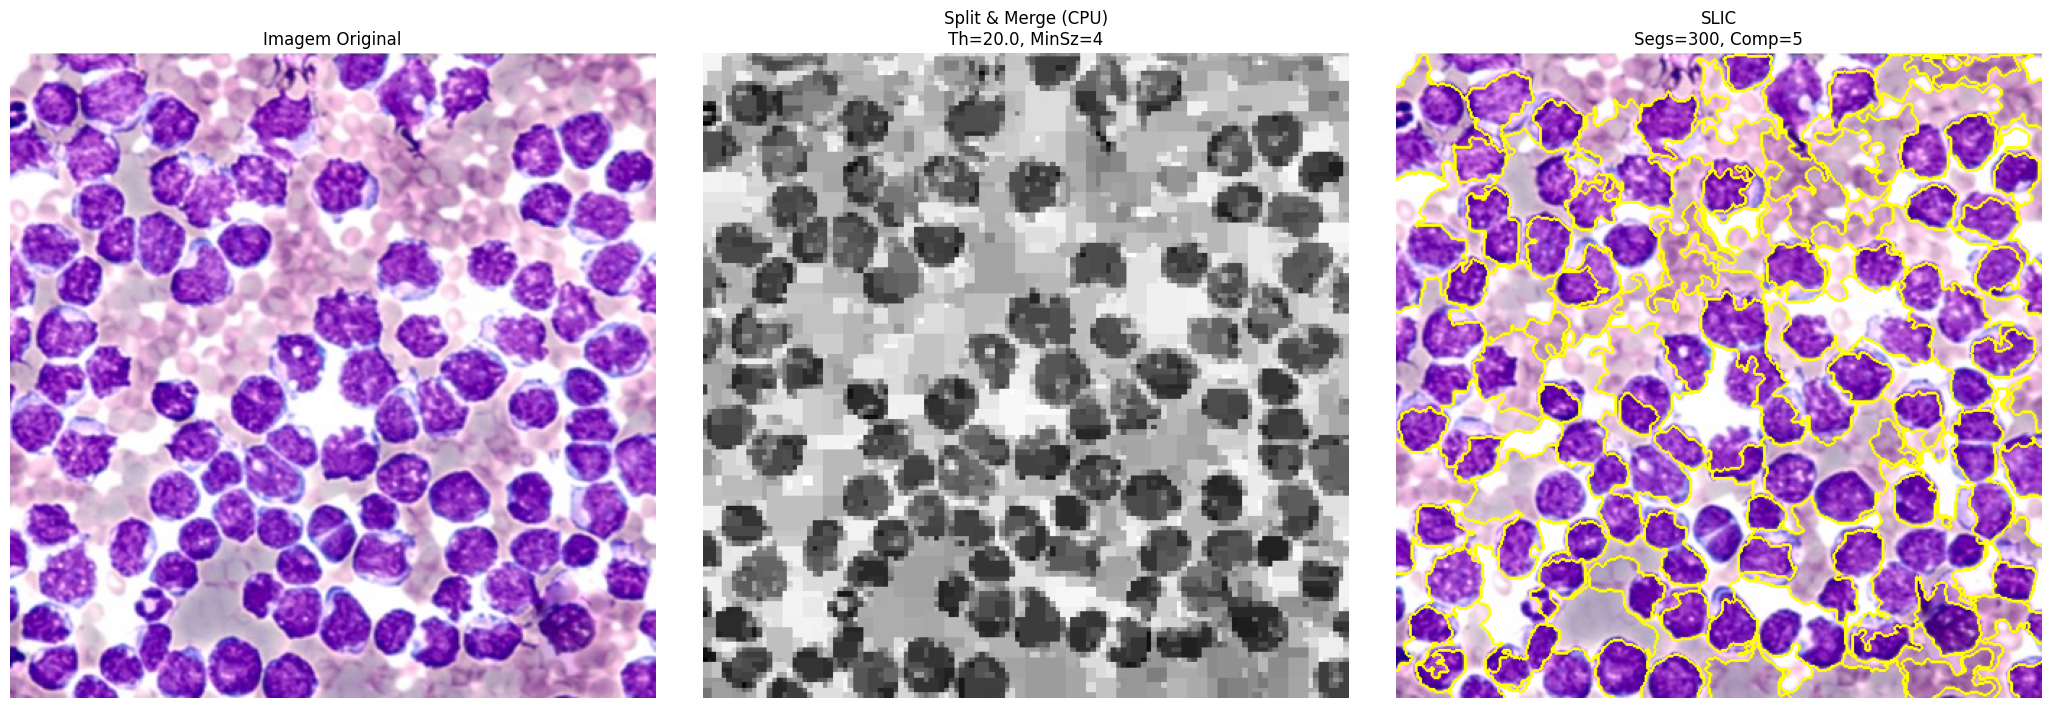


Programa finalizado.


In [20]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import time

# Importações específicas do Scikit-image para SLIC
try:
    from skimage.segmentation import slic, mark_boundaries
    from skimage.util import img_as_float
    # from skimage.data import retina # Usaremos a imagem do usuário
    from skimage import io # Alternativa para carregar imagem
    SKIMAGE_AVAILABLE = True
    print("Scikit-image encontrado. SLIC será executado.")
except ImportError:
    print("Scikit-image não encontrado. Não será possível executar SLIC.")
    SKIMAGE_AVAILABLE = False


# ==============================================================================
# CÓDIGO DO SPLIT AND MERGE (Versão CPU - NumPy)
# ==============================================================================

# --- 1. Predicado de Homogeneidade (Usando NumPy) ---
def predicate_std_dev(region_data, threshold):
    """Verifica se o desvio padrão (NumPy) está abaixo do limiar."""
    if region_data.size == 0: return True
    # Usa np.std diretamente
    std_dev = np.std(region_data)
    return std_dev < threshold

# --- 2. Fase de Divisão (Split) Recursiva (Usando NumPy) ---
def recursive_split(image, x, y, w, h, predicate_func, threshold, min_size=1):
    """Divide recursivamente usando NumPy."""
    current_region_data = image[y : y + h, x : x + w]
    # predicate_func agora usa np.std
    if predicate_func(current_region_data, threshold) or w <= min_size or h <= min_size:
        return [(x, y, w, h)]
    else:
        w2, h2 = w // 2, h // 2
        dw1, dh1 = w2, h2
        dw2, dh2 = w - w2, h - h2
        if w2 == 0 or h2 == 0: return [(x, y, w, h)]
        regions = []
        # Chamadas recursivas passam o array NumPy
        regions.extend(recursive_split(image, x, y, dw1, dh1, predicate_func, threshold, min_size))
        if dw2 > 0: regions.extend(recursive_split(image, x + dw1, y, dw2, dh1, predicate_func, threshold, min_size))
        if dh2 > 0: regions.extend(recursive_split(image, x, y + dh1, dw1, dh2, predicate_func, threshold, min_size))
        if dw2 > 0 and dh2 > 0: regions.extend(recursive_split(image, x + dw1, y + dh1, dw2, dh2, predicate_func, threshold, min_size))
        return regions

# --- 3. Fase de Fusão (Merge) (Usando NumPy) ---
def are_adjacent(r1_coords, r2_coords):
    """Verifica adjacência (lógica de coordenadas, independente de NumPy/CuPy)."""
    x1, y1, w1, h1 = r1_coords
    x2, y2, w2, h2 = r2_coords
    horizontal = (x1 + w1 == x2 or x2 + w2 == x1) and max(y1, y2) < min(y1 + h1, y2 + h2)
    vertical = (y1 + h1 == y2 or y2 + h2 == y1) and max(x1, x2) < min(x1 + w1, x2 + w2)
    return horizontal or vertical

def merge_regions(image, initial_regions, predicate_func, threshold):
    """Funde regiões usando NumPy."""
    num_regions = len(initial_regions)
    if num_regions <= 1: return initial_regions
    print(f"Starting merge phase with {num_regions} regions...")
    region_dict = {i: {'coords': coords} for i, coords in enumerate(initial_regions)}
    merged_something = True
    while merged_something:
        merged_something = False
        keys_to_remove = set()
        processed_pairs = set()
        region_keys = list(region_dict.keys())
        # print(f" Merge pass - current regions: {len(region_keys)}") # Verbose
        start_pass_time = time.time()
        for i in range(len(region_keys)):
            key1 = region_keys[i]
            if key1 in keys_to_remove: continue
            for j in range(i + 1, len(region_keys)):
                key2 = region_keys[j]
                if key2 in keys_to_remove: continue
                pair = tuple(sorted((key1, key2)))
                if pair in processed_pairs: continue
                r1, r2 = region_dict[key1], region_dict[key2]
                if are_adjacent(r1['coords'], r2['coords']):
                    processed_pairs.add(pair)
                    x1, y1, w1, h1 = r1['coords']; x2, y2, w2, h2 = r2['coords']
                    merged_x, merged_y = min(x1, x2), min(y1, y2)
                    merged_w = max(x1 + w1, x2 + w2) - merged_x
                    merged_h = max(y1 + h1, y2 + h2) - merged_y
                    # Combine pixels usando np.concatenate
                    region1_data = image[y1:y1+h1, x1:x1+w1].flatten()
                    region2_data = image[y2:y2+h2, x2:x2+w2].flatten()
                    combined_region_pixels = np.concatenate((region1_data, region2_data)) # <--- USA NP
                    # predicate_func agora usa np.std
                    if predicate_func(combined_region_pixels, threshold):
                        region_dict[key1]['coords'] = (merged_x, merged_y, merged_w, merged_h)
                        keys_to_remove.add(key2)
                        merged_something = True
                        break # Fundiu, vai para o próximo key1
        if keys_to_remove:
            # print(f"   Removing {len(keys_to_remove)} merged regions.") # Verbose
            for key in keys_to_remove:
                if key in region_dict: del region_dict[key]
        end_pass_time = time.time()
        # print(f" Merge pass finished in {end_pass_time - start_pass_time:.2f}s. Regions remaining: {len(region_dict)}") # Verbose
    final_coords = [r['coords'] for r in region_dict.values()]
    print(f"Merge phase finished with {len(final_coords)} regions.")
    return final_coords

# --- 4. Função Principal Split & Merge (CPU - NumPy) ---
def segment_split_and_merge(img_gray_cpu, threshold, min_region_size=4):
    """
    Executa o Split and Merge na imagem em tons de cinza fornecida, usando NumPy.
    Retorna a imagem segmentada como um array NumPy na CPU.
    """
    # Converte para float32 para cálculos de std dev
    img_float_cpu = img_gray_cpu.astype(np.float32)
    rows, cols = img_float_cpu.shape
    print(f"\n--- Iniciando Split & Merge (Threshold={threshold}, MinSize={min_region_size}) ---")
    print("Usando CPU (NumPy) para cálculos.")

    # A imagem já está na CPU como array NumPy
    image_data = img_float_cpu

    # Fase de Divisão
    print("Fase de Divisão...")
    start_time = time.time()
    # Passa o array NumPy
    split_regions = recursive_split(image_data, 0, 0, cols, rows, predicate_std_dev, threshold, min_region_size)
    print(f"Divisão concluída em {time.time() - start_time:.2f}s. Regiões: {len(split_regions)}")

    # Fase de Fusão
    print("Fase de Fusão...")
    start_time = time.time()
    # Passa o array NumPy
    final_regions = merge_regions(image_data, split_regions, predicate_std_dev, threshold)
    print(f"Fusão concluída em {time.time() - start_time:.2f}s. Regiões finais: {len(final_regions)}")

    # Criar Imagem de Saída
    print("Gerando imagem de saída...")
    start_time = time.time()
    # Cria array de saída NumPy
    output_image_cpu = np.zeros_like(image_data, dtype=np.uint8) # <--- USA NP
    for (x, y, w, h) in final_regions:
        y_end, x_end = min(y + h, rows), min(x + w, cols)
        # Slicing no array NumPy
        region_data = image_data[y:y_end, x:x_end]
        if region_data.size > 0:
            # Usa np.mean
            mean_value = np.mean(region_data) # <--- USA NP
            # Preenche o array NumPy de saída
            output_image_cpu[y:y_end, x:x_end] = np.uint8(mean_value) # <--- USA NP
    print(f"Geração da imagem de saída concluída em {time.time() - start_time:.2f}s.")

    # Não há necessidade de transferir de volta da GPU
    print("--- Split & Merge Concluído ---")
    return output_image_cpu # Retorna o array NumPy

# ==============================================================================
# FUNÇÃO PARA APLICAR SLIC (Sem alterações, já usava CPU)
# ==============================================================================
def apply_slic_segmentation(img_color_cpu, n_segments, compactness):
    """
    Aplica o algoritmo SLIC na imagem colorida fornecida.
    Retorna a imagem com as bordas dos segmentos desenhadas.
    """
    if not SKIMAGE_AVAILABLE:
        print("SLIC não pode ser executado pois scikit-image não está disponível.")
        return None

    print(f"\n--- Iniciando SLIC (n_segments={n_segments}, compactness={compactness}) ---")
    start_time = time.time()

    img_rgb_cpu = cv2.cvtColor(img_color_cpu, cv2.COLOR_BGR2RGB)
    img_float = img_as_float(img_rgb_cpu)

    segments_slic = slic(img_float, n_segments=n_segments, compactness=compactness,
                         sigma=1, start_label=1)

    marked_image_float = mark_boundaries(img_float, segments_slic)

    print(f"SLIC concluído em {time.time() - start_time:.2f}s.")
    print("--- SLIC Concluído ---")

    return marked_image_float


# ==============================================================================
# BLOCO PRINCIPAL DE EXECUÇÃO
# ==============================================================================
if __name__ == "__main__":
    # --- Configurações ---
    # Manteve a imagem e parâmetros do seu último exemplo
    image_path = "./lymphomaNonHodgkin.jpg"
    # Parâmetros para Split & Merge
    sm_threshold = 20.0
    sm_min_size = 4
    # Parâmetros para SLIC
    slic_n_segments = 300
    slic_compactness = 5

    # --- Carregar Imagem ---
    try:
        img_color_original = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img_gray_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img_color_original is None or img_gray_original is None:
            print(f"Erro: Não foi possível carregar a imagem de '{image_path}'")
            exit()
        print(f"Imagem '{image_path}' carregada ({img_color_original.shape[1]}x{img_color_original.shape[0]}).")
    except Exception as e:
        print(f"Erro ao carregar a imagem: {e}")
        exit()

    # --- Executar Segmentações ---
    # 1. Split & Merge (agora sempre CPU)
    sm_result_img = segment_split_and_merge(img_gray_original, sm_threshold, sm_min_size)

    # 2. SLIC (CPU)
    slic_result_img = None
    if SKIMAGE_AVAILABLE:
        slic_result_img = apply_slic_segmentation(img_color_original, slic_n_segments, slic_compactness)

    # --- Plotar Resultados ---
    print("\nExibindo resultados...")
    num_plots = 2 + (1 if slic_result_img is not None else 0)
    plt.figure(figsize=(7 * num_plots, 7))

    # Plot 1: Original
    plt.subplot(1, num_plots, 1)
    plt.imshow(cv2.cvtColor(img_color_original, cv2.COLOR_BGR2RGB))
    plt.title('Imagem Original')
    plt.axis('off')

    # Plot 2: Split & Merge (CPU)
    plt.subplot(1, num_plots, 2)
    if sm_result_img is not None:
        plt.imshow(sm_result_img, cmap='gray')
        # Atualiza o título para indicar CPU
        plt.title(f'Split & Merge (CPU)\nTh={sm_threshold}, MinSz={sm_min_size}')
    else:
        plt.text(0.5, 0.5, 'Falha no Split & Merge', horizontalalignment='center', verticalalignment='center')
        plt.title('Split & Merge (Falha)')
    plt.axis('off')

    # Plot 3: SLIC (se disponível)
    if slic_result_img is not None:
        plt.subplot(1, num_plots, 3)
        plt.imshow(slic_result_img)
        plt.title(f'SLIC\nSegs={slic_n_segments}, Comp={slic_compactness}')
        plt.axis('off')
    elif SKIMAGE_AVAILABLE:
        plt.subplot(1, num_plots, 3)
        plt.text(0.5, 0.5, 'Falha no SLIC', horizontalalignment='center', verticalalignment='center')
        plt.title('SLIC (Falha)')
        plt.axis('off')

    plt.tight_layout(pad=1.5)
    plt.show()

    print("\nPrograma finalizado.")